### Парсинг данных и создание датафрейма

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [9]:
runN = "*" # If take all runs set runN = "*"
paths = glob.glob(f"build/Run{runN}_nt_ParticleData_t*.csv") #accel_data_secondary

In [10]:
with open(paths[0], 'r') as f:
    print(f"Headers from file: {paths[0]}")

    hlines = []
    while True:
        line = f.readline()
        if len(line) == 0 or line[0] != '#':
            break
        hlines.append(line)
    title = hlines[1].replace('#title ', '')[:-1]
    sep = chr(int(hlines[2].replace('#separator ', '')[:-1]))
    vsc_sep = chr(int(hlines[3].replace('#vector_separator ', '')[:-1]))
    columns = [' '.join(l.split(' ')[2:])[:-1] for l in hlines[4:]]
    meta_len = len(hlines)
    # print(f'Metarows: {meta_len}\nColumns: {columns}')

Headers from file: build/Run0_nt_ParticleData_t8.csv


In [25]:
pnames = {'annihil':'Аннигиляция','compt':'Комптон-эффект','conv':'Обратная аннигиляция',
          'eBrem':'Тормозное излучение','eIoni':'Ионизационные потери','hadElastic':'?',
          'phot':'Фотоэффект','photonNuclear':'?'}

In [11]:
data = pd.DataFrame()
for path in paths[:10]:
    item = pd.read_csv(path, skiprows=meta_len, names=columns)
    data = pd.concat([data, item], ignore_index=True)

In [12]:
len(data)

64328356

In [6]:
data

,particle_name,creator_process,parentID,energy,z,dE
0,e-,compt,1,0.032766,-19.4246,0.012944
1,e-,compt,1,0.012949,-19.4245,0.019817
2,e-,compt,1,0.000000,-19.4243,0.012949
3,e-,compt,1,0.558379,-18.5898,0.027293
4,e-,compt,1,0.466845,-18.5728,0.091534
...,...,...,...,...,...,...
6414796,e-,compt,1,0.090380,-10.6916,0.020039
6414797,e-,compt,1,0.074532,-10.6940,0.015847
6414798,e-,compt,1,0.035912,-10.6943,0.038620
6414799,e-,compt,1,0.004879,-10.6939,0.031033


In [7]:
l = len(data)
res = []
for name in set(data['particle_name']):
    count = len(data[data['particle_name'] == name])
    res.append((name, count, count/l*100))
    
pd.DataFrame(res, columns=['name', 'count', 'percent'])

,name,count,percent
0,C12,17,0.000265
1,proton,83,0.001294
2,e+,80470,1.254443
3,e-,6131089,95.577228
4,alpha,29,0.000452
5,neutron,19,0.000296
6,N15,3,0.000047
7,O18,6,0.000094
8,gamma,200020,3.118101
9,O16,3064,0.047765


**Вклад вторичных частиц в дозу**

In [27]:
filt = data[data['parentID'] != 0] # Вторичные частицы
filt = filt[filt['creator_process'] != 'user']
total_dose = sum(filt['dE'])

l = len(filt)
res = []
for name in set(filt['particle_name']):
    particle_filt = filt[filt['particle_name'] == name]
    dose = sum(particle_filt['dE'])
    res.append((name, dose, dose/total_dose*100))
pd.DataFrame(res, columns=['name', 'dose', 'dose_percent'])

,name,dose,dose_percent
0,proton,2.179126e+02,9.099049e-03
1,C12,2.053490e+02,8.574451e-03
2,e+,1.020539e+05,4.261311e+00
3,deuteron,1.349282e-03,5.633996e-08
4,e-,2.291409e+06,9.567890e+01
5,alpha,6.316402e+02,2.637445e-02
6,neutron,1.464976e+00,6.117082e-05
7,N15,1.438639e+01,6.007109e-04
8,Be8,2.119136e+00,8.848557e-05
9,O18,3.202822e-03,1.337354e-07


**Доза от глубины**

/tmp/ipykernel_11654/2958221994.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bin_data = nfilt[nfilt['z']>b][nfilt['z']<borders[i+1]]


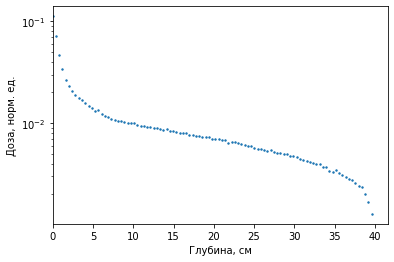

In [17]:
nfilt = data[data['particle_name'] == 'gamma']
bins = []
borders = np.linspace(-20, 20, 100)
for i, b in enumerate(borders[:-1]):
    bin_data = nfilt[nfilt['z']>b][nfilt['z']<borders[i+1]]
    bins.append(sum(bin_data['dE']))
plt.scatter(np.array(borders[:-1])+20, np.array(bins)/sum(np.array(bins)), s=2)
plt.xlim([0, plt.xlim()[1]])
# plt.ylim([0, plt.ylim()[1]])
plt.yscale('log')
plt.ylabel('Доза, норм. ед.')
plt.xlabel('Глубина, см')
plt.show()

/tmp/ipykernel_12458/2208960678.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bin_data = nfilt[nfilt['z']>b][nfilt['z']<borders[i+1]]


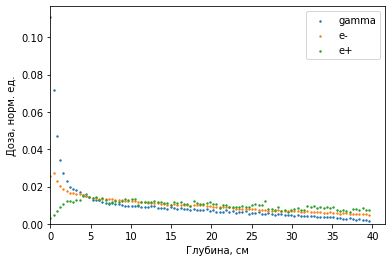

In [62]:
for name in ['gamma', 'e-', 'e+']:
    nfilt = data[data['particle_name'] == name]
    bins = []
    borders = np.linspace(-20, 20, 100)
    for i, b in enumerate(borders[:-1]):
        bin_data = nfilt[nfilt['z']>b][nfilt['z']<borders[i+1]]
        bins.append(sum(bin_data['dE']))
    plt.scatter(np.array(borders[:-1])+20, np.array(bins)/sum(np.array(bins)), s=2, label=name)
    plt.xlim([0, plt.xlim()[1]])
    plt.ylim([0, plt.ylim()[1]])
    # plt.yscale('log')
    plt.legend()
    plt.ylabel('Доза, норм. ед.')
    plt.xlabel('Глубина, см')
plt.show()

**Энергия вторичных частиц**

In [18]:
filt = data[data['parentID'] != 0] # Вторичные частицы
filt = filt[filt['creator_process'] != 'user']
filt = filt[filt['particle_name'] == 'e-'] # Вторичные электроны

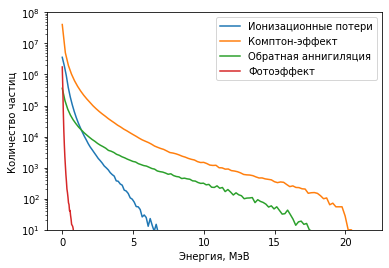

In [24]:
for process in ['eIoni', 'compt', 'conv', 'phot']:
    proc_data = filt[filt['creator_process'] == process]
    # n, e, _ = plt.hist(proc_data['energy'], bins=100)
    n, e = np.histogram(proc_data['energy'], bins=100)
    plt.plot(e[:-1], n, label=pnames[process]) # 
plt.legend()
plt.ylim([10, 10**8])
plt.yscale('log')
plt.ylabel('Количество частиц')
plt.xlabel('Энергия, МэВ')
plt.show()

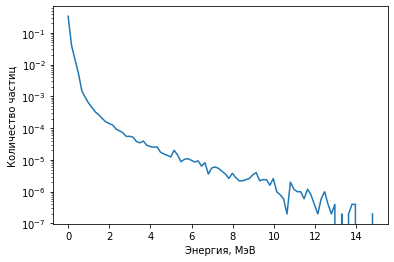

In [13]:
filt = data[data['particle_name'] == 'gamma']
n, e = np.histogram(filt['energy'], bins=100)
n, e = n[:-10], e[:-11]
plt.plot(e, n/(0.5*10**7))
#plt.xlim([0, 20])
#plt.legend()
plt.yscale('log')
plt.ylabel('Количество частиц')
plt.xlabel('Энергия, МэВ')
plt.show()